# Assignment 2
### Data description
Same dataset as assignment 1, details of whom can be visited [here](https://github.com/Aryaman-Chauhan/Machine_Learning_Assignments/blob/main/Assignment%201/data1/census-income_definition.pdf). 
### Tasks to complete
- Deal with missing data
- Further preprocess the data
- Build classifier for predicting salary class of type:
    1. Naive Bayes Classifier
    2. Logistic Regression
    3. Neural Network Classifier with 1, 2 , and 3 hidden layers
- Combine Training and Testing dataset and randomly select 67% for training, using the rest for testing, and check difference in results.
- Compare and find the most optimal classifier:
    1. Naive Bayes Classifier
    2. Logistic Regression
    3. Neural Network Classifier with 1, 2 , and 3 hidden layers
    4. Decision Tree Classifier(Use data from Assignment 1)
    5. Random Forest Classifier
This assignment tries to study vaarious classifier and find the best among them for a dataset which has both discrete and continuous, numeric and non-numeric values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import seaborn as sns
import json
import pickle
import math
%matplotlib inline

## Preprocessing the data
We will preprocess the data somewhat similar to the way we did in assignment 1, where we will imporve some of our oversights to further improve model.
#### Steps to improve the model
- Deal with missing values: We will replace the missing values with the median for that particular column. We're doing this because although mean is a good estimate, it can be heavily affected by outliers. Median prevents that and allows us to keep our data from getting skewed.
- Encode the data. We will encode our data to ensure that it works for classifiers which majorly don't take non-numeric values. We've ensured that this encoding is meaningful, like education increases from preschool to doctorate. The new Encoding can be found [here](https://github.com/Aryaman-Chauhan/Machine_Learning_Assignments/blob/main/Assignment%202/label_mapping.json).
- We will also scale our data this time to ensure that one column doesn't affect the data more that the other. For this we will use StandardScaler from sklearn, which subtracts the mean and divides by standard deviation:
$$ z = \frac{x - \mu}{\sigma} $$
where:
$$ \mu = \frac{1}{N} \sum_{i=1}^N x_i $$ 
as mean and standard deviation:
$$ \sigma = \sqrt{\sum_{i=1}^N \frac{(x_i - \mu)^2}{N}} $$

In [2]:
train_df = pd.read_csv("data/train.csv", na_values="?")
test_df = pd.read_csv("data/test.csv", na_values="?")
train_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
def dfFillNaN(data_df):
    median_values = data_df.median(numeric_only=True)
    data_df = data_df.fillna(median_values)
    processed_df = pd.DataFrame()
    for column in data_df.columns:
        if data_df[column].dtype == 'object':
            mode_value = data_df[column].mode()[0]
            processed_df[column] = data_df[column].fillna(mode_value)
        else:
            processed_df[column] = data_df[column]
    return processed_df

def dfEncoder(data_df, label_mapping_file="label_mapping.json"):
    # Load the label encoding mapping from the JSON file
    with open(label_mapping_file, 'r') as mapping_file:
        label_mapping = json.load(mapping_file)
    
    # Create a new DataFrame to store the encoded data
    encoded_data_df = pd.DataFrame()
    
    for column in data_df.columns:
        if column not in label_mapping:
            encoded_data_df[column] = data_df[column]

    # Iterate over the columns of the input DataFrame
    for column in data_df.columns:
        if column in label_mapping:
            # Create a label encoder and set the classes using the label mapping
            label_encoder = LabelEncoder()
            label_encoder.classes_ = np.append(list(label_mapping[column].values()), len(label_mapping[column].values()))

            # Apply the label encoding to the selected column
            encoded_column = data_df[column].astype(str).fillna(data_df[column].mode()[0]).map(label_mapping[column]).fillna(len(label_mapping[column]))
            encoded_data_df[column+'_n'] = encoded_column
            # encoded_data_df[column] = data_df[column] #Was made to test if encoding was working properly or not
 
    return encoded_data_df

The above functions allow us to process data, where dfFillNaN is used for filling NaN values with median for numeric values and mode for non-numeric values. The dfEncoder processes the data, encoding non-numeric values to meaningful numeric values, which have been stored in label_mapping.json file, which we had prepared beforehand

In [4]:
train_df = dfEncoder(dfFillNaN(train_df))
test_df = dfEncoder(test_df)
train_df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_n,education_n,marital-status_n,occupation_n,relationship_n,race_n,sex_n,native-country_n,class_n
0,39,77516,13,2174,0,40,6,12,4,3,1,4,1,38,0
1,50,83311,13,0,0,13,2,12,2,12,4,4,1,38,0
2,38,215646,9,0,0,40,4,13,0,2,1,4,1,38,0
3,53,234721,7,0,0,40,4,6,2,2,4,2,1,38,0
4,28,338409,13,0,0,40,4,12,2,13,2,2,0,4,0


In [5]:
test_df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_n,education_n,marital-status_n,occupation_n,relationship_n,race_n,sex_n,native-country_n,class_n
0,25,226802,7,0,0,40,4.0,6,4,5.0,5,2,1,38.0,0
1,38,89814,9,0,0,50,4.0,13,2,6.0,4,4,1,38.0,0
2,28,336951,12,0,0,40,5.0,10,2,11.0,4,4,1,38.0,1
3,44,160323,10,7688,0,40,4.0,11,2,5.0,4,2,1,38.0,1
4,18,103497,10,0,0,30,8.0,11,4,14.0,5,4,0,38.0,0


In [6]:
pd.unique(train_df[["occupation","occupation_n"]].values.ravel())

array(['Adm-clerical', 3, 'Exec-managerial', 12, 'Handlers-cleaners', 2,
       'Prof-specialty', 13, 'Other-service', 4, 'Sales', 9,
       'Craft-repair', 8, 'Transport-moving', 7, 'Farming-fishing', 6,
       'Machine-op-inspct', 5, 'Tech-support', 10, 'Protective-serv', 11,
       'Armed-Forces', 0, 'Priv-house-serv', 1], dtype=object)

In [7]:
pd.unique(test_df[["occupation","occupation_n"]].values.ravel())

array(['Machine-op-inspct', 5.0, 'Farming-fishing', 6.0,
       'Protective-serv', 11.0, nan, 14.0, 'Other-service', 4.0,
       'Prof-specialty', 13.0, 'Craft-repair', 8.0, 'Adm-clerical', 3.0,
       'Exec-managerial', 12.0, 'Tech-support', 10.0, 'Sales', 9.0,
       'Priv-house-serv', 1.0, 'Transport-moving', 7.0,
       'Handlers-cleaners', 2.0, 'Armed-Forces', 0.0], dtype=object)

Above two cells tested that our funtions work correctly, encoding the data for training and testing, allowing us to proceed further

In [6]:
sc = StandardScaler()
X_train = train_df.drop(columns="class_n",axis="columns")
Y_train = train_df.class_n
X_test = test_df.drop(columns="class_n",axis="columns")
Y_test = test_df.class_n
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

The Standard Scaler Scales the data for X_train, and uses the same scaling to scale X_test, that's why we fit sc to training data, and directly transform testing data.
With this, we have correctly preprocessed the data and can now move to training this data on different models.

In [7]:
X_train[0], X_train.shape, X_test[0], X_test.shape

(array([ 0.03067056, -1.06361075,  1.13473876,  0.1484529 , -0.21665953,
        -0.03542945,  2.13703018,  0.344423  ,  0.92163395, -1.35898941,
        -1.34525764,  0.38419018,  0.70307135,  0.26136999]),
 (32561, 14),
 array([-0.99570562,  0.35077413, -1.19745882, -0.14592048, -0.21665953,
        -0.03542945, -0.04356366, -1.74846817,  0.92163395, -0.82418415,
         1.25702568, -2.30489334,  0.70307135,  0.26136999]),
 (16281, 14))

## Naive Bayes Classifier
For this classifier, we will use GaussianNB from sklearn library, which assumes the data to be in normal distribution, as we have studied in class.

In [47]:
naiveGauss = GaussianNB()
X_train_nb, Y_train_nb, X_test_nb, Y_test_nb = X_train.copy(), Y_train.copy(), X_test.copy(), Y_test.copy()
naiveGauss.fit(X_train_nb, Y_train_nb)

GaussianNB()

In [88]:
Y_pred_nb = naiveGauss.predict(X_test_nb)
cm_nb = confusion_matrix(Y_test_nb, Y_pred_nb)

In [64]:
naiveGauss.score(X_train_nb, Y_train_nb)

0.8192008844937195

In [52]:
naiveGauss.score(X_test_nb, Y_test_nb)

0.8161046618758061

(array([0.5, 1.5]), [Text(0.5, 0, '<50K'), Text(1.5, 0, '>=50K')])

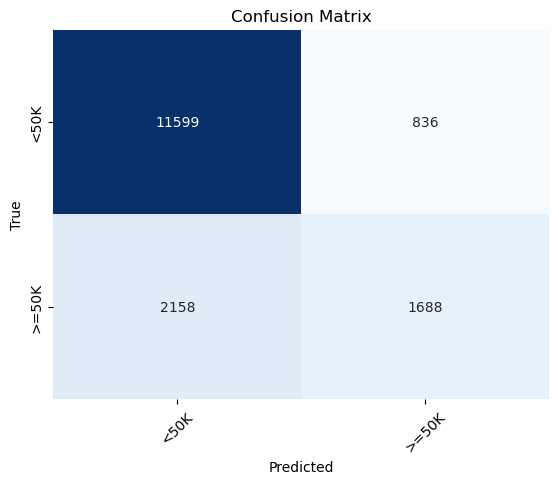

In [89]:
class_labels = ['<50K', '>=50K']
fig_nb, ax_nb = plt.subplots()

# Create a heatmap using seaborn
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax_nb)

ax_nb.set_xlabel('Predicted')
ax_nb.set_ylabel('True')
ax_nb.set_title('Confusion Matrix')
ax_nb.xaxis.set_ticklabels(class_labels)
ax_nb.yaxis.set_ticklabels(class_labels)
fig_nb.savefig('CM_Naive.png')
plt.xticks(rotation=45)

In [80]:
with open('gnb_model.pkl', 'wb') as file:
    pickle.dump(naiveGauss, file)

In [81]:
with open('gnb_model.pkl', 'rb') as file:
    naiveGauss = pickle.load(file)

In [ ]:
X_train_nb, Y_train_nb, X_test_nb, Y_test_nb = None, None, None, None

Saved model, so easy to retrieve results, and derefernced the arrays to save memory

## Logistic Regression Classifier

In [86]:
logReg = LogisticRegression(penalty=None, random_state=0,max_iter=500, multi_class='ovr',n_jobs=4)
X_train_lr, Y_train_lr, X_test_lr, Y_test_lr = X_train.copy(), Y_train.copy(), X_test.copy(), Y_test.copy()
logReg.fit(X_train_lr, Y_train_lr)

LogisticRegression(max_iter=500, multi_class='ovr', n_jobs=4, penalty=None,
                   random_state=0)

(array([0.5, 1.5]), [Text(0.5, 0, '<50K'), Text(1.5, 0, '>=50K')])

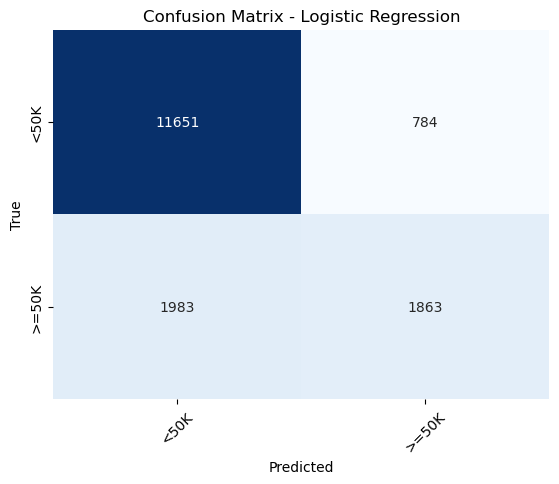

In [87]:
Y_pred_lr = logReg.predict(X_test_lr)
cm_lr = confusion_matrix(Y_test_lr, Y_pred_lr)
class_labels = ['<50K', '>=50K']
fig_lr, ax_lr = plt.subplots()

# Create a heatmap using seaborn
heatmap = sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax_lr)

ax_lr.set_xlabel('Predicted')
ax_lr.set_ylabel('True')
ax_lr.set_title('Confusion Matrix - Logistic Regression')
ax_lr.xaxis.set_ticklabels(class_labels)
ax_lr.yaxis.set_ticklabels(class_labels)
fig_lr.savefig('CM_Logistic.png')
plt.xticks(rotation=45)

In [96]:
logReg.score(X_train_lr, Y_train_lr)

0.8327139829857806

In [95]:
logReg.score(X_test_lr, Y_test_lr)

0.8300472943922363

In [92]:
with open('lr_model.pkl','wb') as file:
    pickle.dump(logReg, file)

In [93]:
with open('lr_model.pkl', 'rb') as file:
    logReg = pickle.load(file)

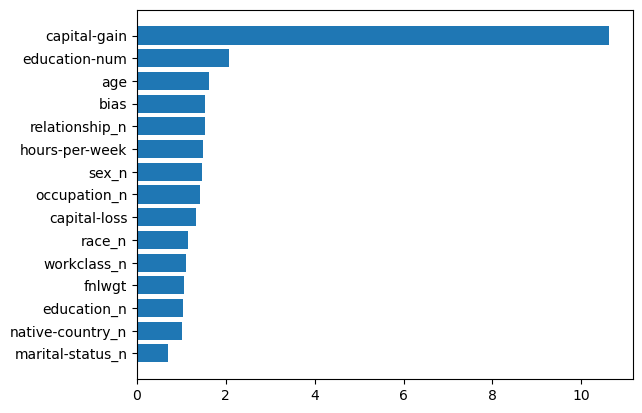

In [122]:
cw = logReg.coef_[0]
cw0 = logReg.intercept_[0]
feature_importance_lr = pd.DataFrame(train_df.drop(columns='class_n', axis='columns').columns, columns = ["attribute"])
feature_importance_lr["importance"] = pow(math.e, cw)

bias_row = pd.DataFrame({'attribute':['bias'], 
                         'importance':[abs(cw0)]}, index=[0])
feature_importance_lr = pd.concat([feature_importance_lr, bias_row], ignore_index=True)
feature_importance_lr = feature_importance_lr.sort_values(by = ["importance"], ascending=False)

fig_lrfi, ax_lrfi = plt.subplots()
ax_lrfi.barh(feature_importance_lr.attribute, feature_importance_lr.importance)
ax_lrfi.invert_yaxis()
fig_lrfi.savefig('Logistic_FI.png')

Equation of the Logistic Regression:
$$ y = 0.00591408x_{14} + 0.37565091x_{13} + 0.13533394x_{12} + 0.42481656x_{11} + 0.3455405x_{10} - 0.3532019x_{9} + 0.02593252x_8 + 0.10430457x_7 + 0.40112813x_6 + 0.27644223x_5 + 2.36383934x_4 + 0.73036156x_3 + 0.0653556x_2 + 0.48746454x - 1.5406325451872802 $$
where x represent as follows: 14:age, 13:fnlwgt, 12:education-num, 11:capital-gain, 10:capital-loss, 9:hours-per-week, 8:workclass_n, 7:education_n, 6:marital-status_n, 5:occupation_n, 4:relationship_n, 3:race_n, 2:sex_n, 1:native-country_n, 0:bias

In [ ]:
X_train_lr, Y_train_lr, X_test_lr, Y_test_lr = None, None, None, None
#Emptying arrays to save memory

## Neural Network with 1 Hidden Layer

In [8]:
X_train_nn1, Y_train_nn1, X_test_nn1, Y_test_nn1 = X_train.copy(), Y_train.copy(), X_test.copy(), Y_test.copy()
X_train_nn1.shape, Y_train_nn1.shape

((32561, 14), (32561,))

In [9]:
X_train_nn1 = torch.from_numpy(X_train_nn1).type(torch.float32)
Y_train_nn1 = torch.from_numpy(Y_train_nn1.to_numpy()).type(torch.float32)
X_test_nn1 = torch.from_numpy(X_test_nn1).type(torch.float32)
Y_test_nn1 = torch.from_numpy(Y_test_nn1.to_numpy()).type(torch.float32)
X_train_nn1[:5],Y_train_nn1[:5]

(tensor([[ 0.0307, -1.0636,  1.1347,  0.1485, -0.2167, -0.0354,  2.1370,  0.3444,
           0.9216, -1.3590, -1.3453,  0.3842,  0.7031,  0.2614],
         [ 0.8371, -1.0087,  1.1347, -0.1459, -0.2167, -2.2222, -2.2242,  0.3444,
          -0.4062,  1.0476,  0.6065,  0.3842,  0.7031,  0.2614],
         [-0.0426,  0.2451, -0.4201, -0.1459, -0.2167, -0.0354, -0.0436,  0.6932,
          -1.7341, -1.6264, -1.3453,  0.3842,  0.7031,  0.2614],
         [ 1.0570,  0.4258, -1.1975, -0.1459, -0.2167, -0.0354, -0.0436, -1.7485,
          -0.4062, -1.6264,  0.6065, -2.3049,  0.7031,  0.2614],
         [-0.7758,  1.4082,  1.1347, -0.1459, -0.2167, -0.0354, -0.0436,  0.3444,
          -0.4062,  1.3150, -0.6947, -2.3049, -1.4223, -5.3529]]),
 tensor([0., 0., 0., 0., 0.]))

In [10]:
X_test_nn1, X_valid_nn1, Y_test_nn1, Y_valid_nn1 = train_test_split(X_test_nn1, Y_test_nn1, train_size=0.5, random_state=10)
X_test_nn1.shape, X_valid_nn1.shape

(torch.Size([8140, 14]), torch.Size([8141, 14]))

In [18]:
model_nn1 = nn.Sequential(nn.Linear(in_features=14, out_features=10),#Input Layer to Hidden Layer
                          nn.Sigmoid(),#Non-Linear Function
                          nn.Linear(in_features=10, out_features=1))#Hidden Layer to Output Layer

In [19]:
loss_nn1 = nn.BCEWithLogitsLoss()#Non-Linear Function to get probability of class inclusive here
grad_nn1 = torch.optim.SGD(model_nn1.parameters(), lr=0.001)

In [5]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [20]:
torch.manual_seed(6)
train_loss_values = []
test_loss_values = []
epoch_count = []
train_accuracy_values = []
valid_accuracy_values = []
for epoch in range(10000):
    ## Training    
    # Set Training mode
    model_nn1.train()
    
    # Forward Pass
    y_pred_nn1logits = model_nn1(X_train_nn1).squeeze()
    y_pred_nn1 = torch.round(torch.sigmoid(y_pred_nn1logits))
    
    # Calculating loss
    losstrain = loss_nn1(y_pred_nn1logits, Y_train_nn1)
    
    epoch_count.append(epoch)
    train_loss_values.append(losstrain.item())
    train_acc = accuracy_fn(y_true=Y_train_nn1, y_pred=y_pred_nn1)
    train_accuracy_values.append(train_acc)
    
    # Zero Grad of optimizer
    grad_nn1.zero_grad()
    
    # Backward Propogation
    losstrain.backward()
    
    # Progress the optimizer
    grad_nn1.step()
    
    ## Validation
    # Setting evaluation mode
    model_nn1.eval()
    
    with torch.inference_mode():
        valid_predlogits = model_nn1(X_valid_nn1).squeeze()
        valid_pred = torch.round(torch.sigmoid(valid_predlogits))
        loss_valid = loss_nn1(valid_predlogits, Y_valid_nn1)
        test_loss_values.append(loss_valid.item())
        valid_acc = accuracy_fn(y_true=Y_valid_nn1, y_pred=valid_pred)
        valid_accuracy_values.append(valid_acc)
        
    if epoch%500==0:
        print(f"Epoch: {epoch} | Loss: {losstrain.item()}, Accuracy: {train_acc:.2f}% | Test Loss: {loss_valid.item()}, Test Accuracy: {valid_acc:.2f}%")

Epoch: 0 | Loss: 0.791131854057312, Accuracy: 24.08% | Test Loss: 0.7924141883850098, Test Accuracy: 24.05%
Epoch: 500 | Loss: 0.6611313223838806, Accuracy: 73.24% | Test Loss: 0.6628499627113342, Test Accuracy: 71.66%
Epoch: 1000 | Loss: 0.606642484664917, Accuracy: 75.92% | Test Loss: 0.6084097623825073, Test Accuracy: 75.95%
Epoch: 1500 | Loss: 0.5822102427482605, Accuracy: 75.92% | Test Loss: 0.5839201807975769, Test Accuracy: 75.95%
Epoch: 2000 | Loss: 0.5701276063919067, Accuracy: 75.92% | Test Loss: 0.571763277053833, Test Accuracy: 75.95%
Epoch: 2500 | Loss: 0.5633936524391174, Accuracy: 75.92% | Test Loss: 0.5649623870849609, Test Accuracy: 75.95%
Epoch: 3000 | Loss: 0.5590925812721252, Accuracy: 75.92% | Test Loss: 0.5606070756912231, Test Accuracy: 75.95%
Epoch: 3500 | Loss: 0.5559465289115906, Accuracy: 75.92% | Test Loss: 0.5574185252189636, Test Accuracy: 75.95%
Epoch: 4000 | Loss: 0.553370475769043, Accuracy: 75.92% | Test Loss: 0.5548095107078552, Test Accuracy: 75.95%


In [28]:
model_nn1.eval()
with torch.inference_mode():
    train_pred = model_nn1(X_train_nn1).squeeze()
    
train_pred = torch.round(torch.sigmoid(train_pred))
train_acc = accuracy_fn(y_true=Y_train_nn1, y_pred=train_pred)
train_acc

75.91904425539757

In [27]:
model_nn1.eval()
with torch.inference_mode():
    test_pred = model_nn1(X_test_nn1).squeeze()
    
test_pred = torch.round(torch.sigmoid(test_pred))
test_acc = accuracy_fn(y_true=Y_test_nn1, y_pred=test_pred)
test_acc

76.8058968058968

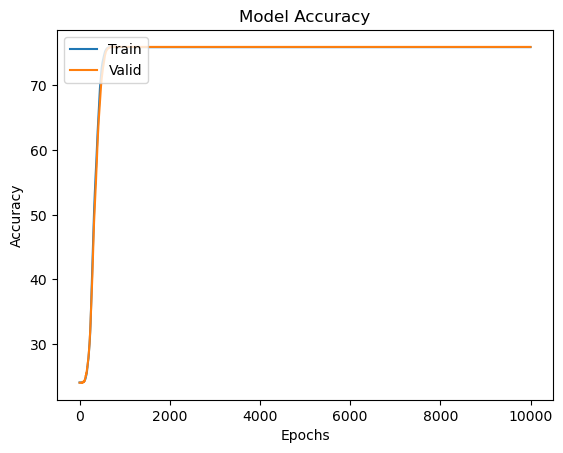

In [23]:
plt.plot(epoch_count, train_accuracy_values)
plt.plot(epoch_count, valid_accuracy_values)
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train','Valid'], loc='upper left')
plt.savefig('Acc1Hidden.png')

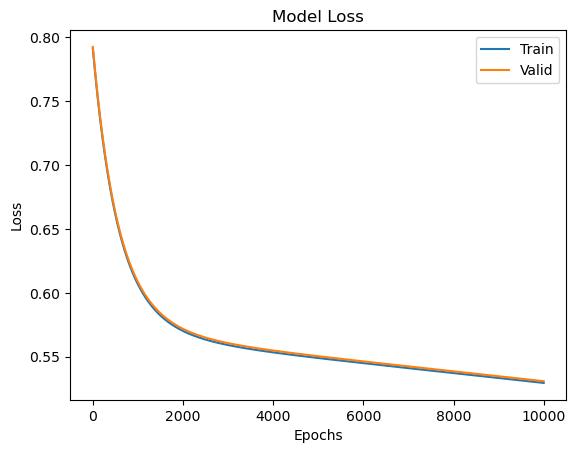

In [24]:
plt.plot(epoch_count, train_loss_values)
plt.plot(epoch_count, test_loss_values)
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train','Valid'], loc='upper right')
plt.savefig('Loss1Hidden.png')

In [25]:
torch.save(model_nn1.state_dict(), f="NN1.pth")

In [26]:
model_nn1.load_state_dict(torch.load(f='NN1.pth'))

<All keys matched successfully>

In [29]:
X_train_nn1, Y_train_nn1, X_test_nn1, X_valid_nn1, Y_test_nn1, Y_valid_nn1 = None, None, None, None, None, None

## Neural Network with 2 Hidden Layer

In [30]:
X_train_nn2, Y_train_nn2, X_test_nn2, Y_test_nn2 = X_train.copy(), Y_train.copy(), X_test.copy(), Y_test.copy()
X_train_nn2.shape, Y_train_nn2.shape

((32561, 14), (32561,))

In [31]:
X_train_nn2 = torch.from_numpy(X_train_nn2).type(torch.float32)
Y_train_nn2 = torch.from_numpy(Y_train_nn2.to_numpy()).type(torch.float32)
X_test_nn2 = torch.from_numpy(X_test_nn2).type(torch.float32)
Y_test_nn2 = torch.from_numpy(Y_test_nn2.to_numpy()).type(torch.float32)
X_train_nn2[:5],Y_train_nn2[:5]

(tensor([[ 0.0307, -1.0636,  1.1347,  0.1485, -0.2167, -0.0354,  2.1370,  0.3444,
           0.9216, -1.3590, -1.3453,  0.3842,  0.7031,  0.2614],
         [ 0.8371, -1.0087,  1.1347, -0.1459, -0.2167, -2.2222, -2.2242,  0.3444,
          -0.4062,  1.0476,  0.6065,  0.3842,  0.7031,  0.2614],
         [-0.0426,  0.2451, -0.4201, -0.1459, -0.2167, -0.0354, -0.0436,  0.6932,
          -1.7341, -1.6264, -1.3453,  0.3842,  0.7031,  0.2614],
         [ 1.0570,  0.4258, -1.1975, -0.1459, -0.2167, -0.0354, -0.0436, -1.7485,
          -0.4062, -1.6264,  0.6065, -2.3049,  0.7031,  0.2614],
         [-0.7758,  1.4082,  1.1347, -0.1459, -0.2167, -0.0354, -0.0436,  0.3444,
          -0.4062,  1.3150, -0.6947, -2.3049, -1.4223, -5.3529]]),
 tensor([0., 0., 0., 0., 0.]))

In [32]:
X_test_nn2, X_valid_nn2, Y_test_nn2, Y_valid_nn2 = train_test_split(X_test_nn2, Y_test_nn2, train_size=0.5, random_state=0)
X_test_nn2.shape, X_valid_nn2.shape

(torch.Size([8140, 14]), torch.Size([8141, 14]))

In [36]:
model_nn2 = nn.Sequential(nn.Linear(in_features=14, out_features=9),#Input Layer to Hidden Layer
                          nn.Sigmoid(),#Non-Linear Function
                          nn.Linear(in_features=9, out_features=9),#Hidden Layer to Hidden Layer
                          nn.Sigmoid(),#Non-Linear Function
                          nn.Linear(in_features=9, out_features=1))#Hidden Layer to Output Layer

In [37]:
loss_nn2 = nn.BCEWithLogitsLoss()#Non-Linear Function to get probability of class inclusive here
grad_nn2 = torch.optim.SGD(model_nn2.parameters(), lr=0.001)

In [38]:
torch.manual_seed(6)
train_loss_values2 = []
test_loss_values2 = []
epoch_count2 = []
train_accuracy_values2 = []
valid_accuracy_values2 = []
for epoch in range(10000):
    ## Training    
    # Set Training mode
    model_nn2.train()
    
    # Forward Pass
    y_pred_nn2logits = model_nn2(X_train_nn2).squeeze()
    y_pred_nn2 = torch.round(torch.sigmoid(y_pred_nn2logits))
    
    # Calculating loss
    losstrain = loss_nn2(y_pred_nn2logits, Y_train_nn2)
    
    epoch_count2.append(epoch)
    train_loss_values2.append(losstrain.item())
    train_acc = accuracy_fn(y_true=Y_train_nn2, y_pred=y_pred_nn2)
    train_accuracy_values2.append(train_acc)
    
    # Zero Grad of optimizer
    grad_nn2.zero_grad()
    
    # Backward Propogation
    losstrain.backward()
    
    # Progress the optimizer
    grad_nn2.step()
    
    ## Validation
    # Setting evaluation mode
    model_nn2.eval()
    
    with torch.inference_mode():
        valid_predlogits = model_nn2(X_valid_nn2).squeeze()
        valid_pred = torch.round(torch.sigmoid(valid_predlogits))
        loss_valid = loss_nn2(valid_predlogits, Y_valid_nn2)
        test_loss_values2.append(loss_valid.item())
        valid_acc = accuracy_fn(y_true=Y_valid_nn2, y_pred=valid_pred)
        valid_accuracy_values2.append(valid_acc)
        
    if epoch%500==0:
        print(f"Epoch: {epoch} | Loss: {losstrain.item()}, Accuracy: {train_acc:.2f}% | Test Loss: {loss_valid.item()}, Test Accuracy: {valid_acc:.2f}%")

Epoch: 0 | Loss: 0.8671633005142212, Accuracy: 24.08% | Test Loss: 0.8663463592529297, Test Accuracy: 24.10%
Epoch: 500 | Loss: 0.6954934000968933, Accuracy: 35.85% | Test Loss: 0.6951804757118225, Test Accuracy: 37.49%
Epoch: 1000 | Loss: 0.6190558075904846, Accuracy: 75.92% | Test Loss: 0.6189910173416138, Test Accuracy: 75.90%
Epoch: 1500 | Loss: 0.5843772292137146, Accuracy: 75.92% | Test Loss: 0.5844386219978333, Test Accuracy: 75.90%
Epoch: 2000 | Loss: 0.5680569410324097, Accuracy: 75.92% | Test Loss: 0.5681871771812439, Test Accuracy: 75.90%
Epoch: 2500 | Loss: 0.5601016879081726, Accuracy: 75.92% | Test Loss: 0.5602722764015198, Test Accuracy: 75.90%
Epoch: 3000 | Loss: 0.5561074018478394, Accuracy: 75.92% | Test Loss: 0.5563032031059265, Test Accuracy: 75.90%
Epoch: 3500 | Loss: 0.5540502071380615, Accuracy: 75.92% | Test Loss: 0.5542625188827515, Test Accuracy: 75.90%
Epoch: 4000 | Loss: 0.5529645085334778, Accuracy: 75.92% | Test Loss: 0.5531880259513855, Test Accuracy: 75.

In [39]:
model_nn2.eval()
with torch.inference_mode():
    train_pred = model_nn2(X_train_nn2).squeeze()
    
train_pred = torch.round(torch.sigmoid(train_pred))
train_acc = accuracy_fn(y_true=Y_train_nn2, y_pred=train_pred)
train_acc

75.91904425539757

In [40]:
model_nn2.eval()
with torch.inference_mode():
    test_pred = model_nn2(X_test_nn2).squeeze()
    
test_pred = torch.round(torch.sigmoid(test_pred))
test_acc = accuracy_fn(y_true=Y_test_nn2, y_pred=test_pred)
test_acc

76.85503685503686

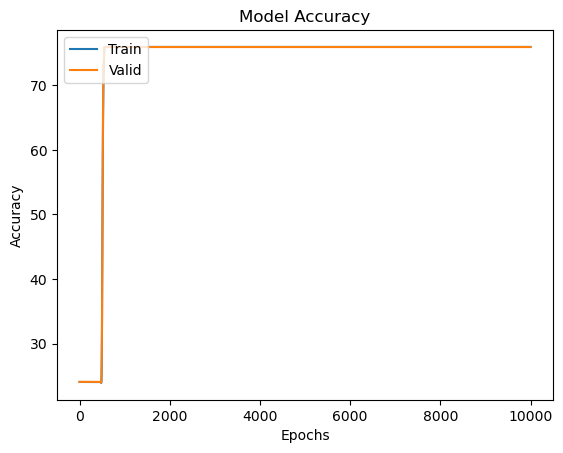

In [41]:
plt.plot(epoch_count2, train_accuracy_values2)
plt.plot(epoch_count2, valid_accuracy_values2)
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train','Valid'], loc='upper left')
plt.savefig('Acc2Hidden.png')

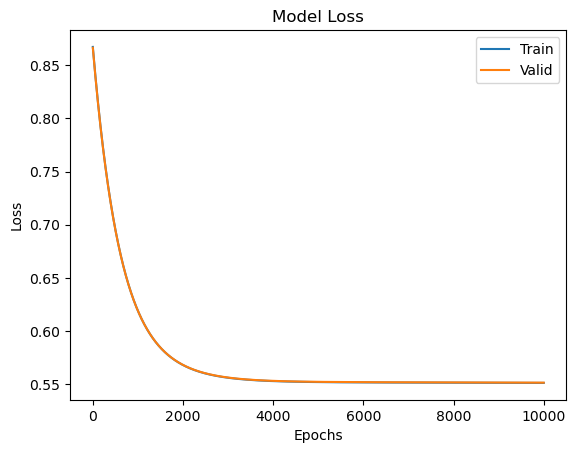

In [42]:
plt.plot(epoch_count2, train_loss_values2)
plt.plot(epoch_count2, test_loss_values2)
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train','Valid'], loc='upper right')
plt.savefig('Loss2Hidden.png')

In [43]:
torch.save(model_nn2.state_dict(),f='NN2.pth')

In [44]:
model_nn2.load_state_dict(torch.load(f='NN2.pth'))

<All keys matched successfully>

In [45]:
X_train_nn2, Y_train_nn2, X_test_nn2, X_valid_nn2, Y_test_nn2, Y_valid_nn2 = None, None, None, None, None, None

## Neural Network with 3 Hidden Layer

In [46]:
X_train_nn3, Y_train_nn3, X_test_nn3, Y_test_nn3 = X_train.copy(), Y_train.copy(), X_test.copy(), Y_test.copy()
X_train_nn3.shape, Y_train_nn3.shape

((32561, 14), (32561,))

In [47]:
X_train_nn3 = torch.from_numpy(X_train_nn3).type(torch.float32)
Y_train_nn3 = torch.from_numpy(Y_train_nn3.to_numpy()).type(torch.float32)
X_test_nn3 = torch.from_numpy(X_test_nn3).type(torch.float32)
Y_test_nn3 = torch.from_numpy(Y_test_nn3.to_numpy()).type(torch.float32)
X_train_nn3[:5],Y_train_nn3[:5]

(tensor([[ 0.0307, -1.0636,  1.1347,  0.1485, -0.2167, -0.0354,  2.1370,  0.3444,
           0.9216, -1.3590, -1.3453,  0.3842,  0.7031,  0.2614],
         [ 0.8371, -1.0087,  1.1347, -0.1459, -0.2167, -2.2222, -2.2242,  0.3444,
          -0.4062,  1.0476,  0.6065,  0.3842,  0.7031,  0.2614],
         [-0.0426,  0.2451, -0.4201, -0.1459, -0.2167, -0.0354, -0.0436,  0.6932,
          -1.7341, -1.6264, -1.3453,  0.3842,  0.7031,  0.2614],
         [ 1.0570,  0.4258, -1.1975, -0.1459, -0.2167, -0.0354, -0.0436, -1.7485,
          -0.4062, -1.6264,  0.6065, -2.3049,  0.7031,  0.2614],
         [-0.7758,  1.4082,  1.1347, -0.1459, -0.2167, -0.0354, -0.0436,  0.3444,
          -0.4062,  1.3150, -0.6947, -2.3049, -1.4223, -5.3529]]),
 tensor([0., 0., 0., 0., 0.]))

In [48]:
X_test_nn3, X_valid_nn3, Y_test_nn3, Y_valid_nn3 = train_test_split(X_test_nn3, Y_test_nn3, train_size=0.5, random_state=0)
X_test_nn3.shape, X_valid_nn3.shape

(torch.Size([8140, 14]), torch.Size([8141, 14]))

In [49]:
model_nn3 = nn.Sequential(nn.Linear(in_features=14, out_features=9),#Input Layer to Hidden Layer1
                          nn.Sigmoid(),#Non-Linear Function
                          nn.Linear(in_features=9, out_features=9),#Hidden Layer1 to Hidden Layer2
                          nn.Sigmoid(),#Non-Linear Function
                          nn.Linear(in_features=9, out_features=9),#Hidden Layer2 to Hidden Layer3
                          nn.Sigmoid(),#Non-Linear Function
                          nn.Linear(in_features=9, out_features=1))#Hidden Layer3 to Output Layer

In [50]:
loss_nn3 = nn.BCEWithLogitsLoss()#Non-Linear Function to get probability of class inclusive here
grad_nn3 = torch.optim.SGD(model_nn3.parameters(), lr=0.001)

In [51]:
torch.manual_seed(6)
train_loss_values3 = []
test_loss_values3 = []
epoch_count3 = []
train_accuracy_values3 = []
valid_accuracy_values3 = []
for epoch in range(10000):
    ## Training    
    # Set Training mode
    model_nn3.train()
    
    # Forward Pass
    y_pred_nn3logits = model_nn3(X_train_nn3).squeeze()
    y_pred_nn3 = torch.round(torch.sigmoid(y_pred_nn3logits))
    
    # Calculating loss
    losstrain = loss_nn3(y_pred_nn3logits, Y_train_nn3)
    
    epoch_count3.append(epoch)
    train_loss_values3.append(losstrain.item())
    train_acc = accuracy_fn(y_true=Y_train_nn3, y_pred=y_pred_nn3)
    train_accuracy_values3.append(train_acc)
    
    # Zero Grad of optimizer
    grad_nn3.zero_grad()
    
    # Backward Propogation
    losstrain.backward()
    
    # Progress the optimizer
    grad_nn3.step()
    
    ## Validation
    # Setting evaluation mode
    model_nn3.eval()
    
    with torch.inference_mode():
        valid_predlogits = model_nn3(X_valid_nn3).squeeze()
        valid_pred = torch.round(torch.sigmoid(valid_predlogits))
        loss_valid = loss_nn3(valid_predlogits, Y_valid_nn3)
        test_loss_values3.append(loss_valid.item())
        valid_acc = accuracy_fn(y_true=Y_valid_nn3, y_pred=valid_pred)
        valid_accuracy_values3.append(valid_acc)
        
    if epoch%500==0:
        print(f"Epoch: {epoch} | Loss: {losstrain.item()}, Accuracy: {train_acc:.2f}% | Test Loss: {loss_valid.item()}, Test Accuracy: {valid_acc:.2f}%")

Epoch: 0 | Loss: 0.799547016620636, Accuracy: 24.08% | Test Loss: 0.799138605594635, Test Accuracy: 24.10%
Epoch: 500 | Loss: 0.6674513220787048, Accuracy: 75.92% | Test Loss: 0.6673227548599243, Test Accuracy: 75.90%
Epoch: 1000 | Loss: 0.6075656414031982, Accuracy: 75.92% | Test Loss: 0.6075791716575623, Test Accuracy: 75.90%
Epoch: 1500 | Loss: 0.5796221494674683, Accuracy: 75.92% | Test Loss: 0.5797115564346313, Test Accuracy: 75.90%
Epoch: 2000 | Loss: 0.566107451915741, Accuracy: 75.92% | Test Loss: 0.5662403702735901, Test Accuracy: 75.90%
Epoch: 2500 | Loss: 0.559364378452301, Accuracy: 75.92% | Test Loss: 0.55952388048172, Test Accuracy: 75.90%
Epoch: 3000 | Loss: 0.5559167265892029, Accuracy: 75.92% | Test Loss: 0.5560934543609619, Test Accuracy: 75.90%
Epoch: 3500 | Loss: 0.5541212558746338, Accuracy: 75.92% | Test Loss: 0.5543093681335449, Test Accuracy: 75.90%
Epoch: 4000 | Loss: 0.5531730651855469, Accuracy: 75.92% | Test Loss: 0.5533690452575684, Test Accuracy: 75.90%
Ep

In [52]:
model_nn3.eval()
with torch.inference_mode():
    train_pred = model_nn3(X_train_nn3).squeeze()
    
train_pred = torch.round(torch.sigmoid(train_pred))
train_acc = accuracy_fn(y_true=Y_train_nn3, y_pred=train_pred)
train_acc

75.91904425539757

In [53]:
model_nn3.eval()
with torch.inference_mode():
    test_pred = model_nn3(X_test_nn3).squeeze()
    
test_pred = torch.round(torch.sigmoid(test_pred))
test_acc = accuracy_fn(y_true=Y_test_nn3, y_pred=test_pred)
test_acc

76.85503685503686

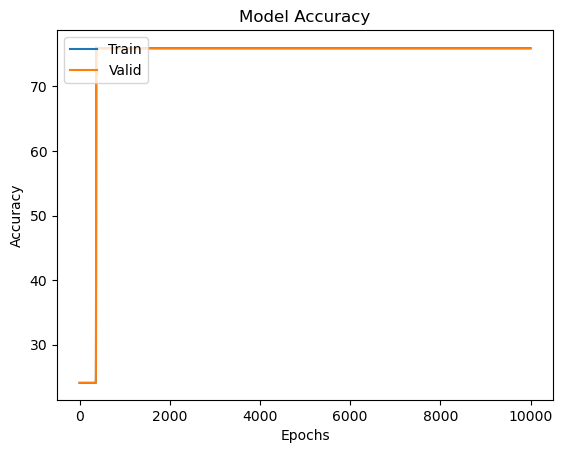

In [54]:
plt.plot(epoch_count3, train_accuracy_values3)
plt.plot(epoch_count3, valid_accuracy_values3)
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train','Valid'], loc='upper left')
plt.savefig('Acc3Hidden.png')

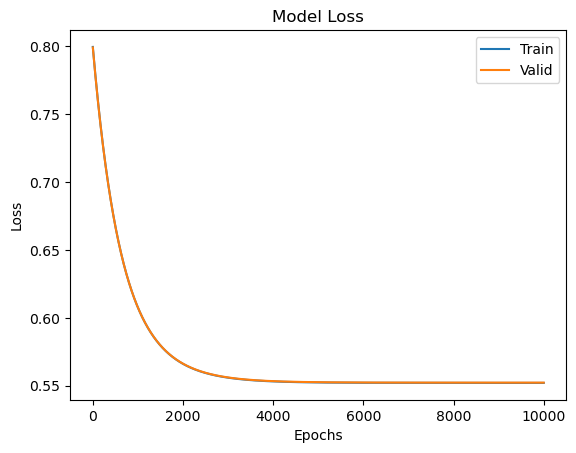

In [55]:
plt.plot(epoch_count3, train_loss_values3)
plt.plot(epoch_count3, test_loss_values3)
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train','Valid'], loc='upper right')
plt.savefig('Loss3Hidden.png')

In [56]:
torch.save(model_nn3.state_dict(),f='NN3.pth')

In [57]:
model_nn3.load_state_dict(torch.load(f='NN3.pth'))

<All keys matched successfully>

In [58]:
X_train_nn3, Y_train_nn3, X_test_nn3, X_valid_nn3, Y_test_nn3, Y_valid_nn3 = None, None, None, None, None, None

## Random Data
Here, we will use train test split, first combining the data and then randomly selecting 67% for training, and 33% for testing, this is to check wether the data is well distributed or not. Let's start with preprocessing the data.

### Preprocessing the data

In [2]:
combined_df = pd.read_csv('data/combined.csv', na_values='?')
combined_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
combined_df = dfEncoder(dfFillNaN(combined_df))
combined_df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_n,education_n,marital-status_n,occupation_n,relationship_n,race_n,sex_n,native-country_n,class_n
0,39,77516,13,2174,0,40,6,12,4,3,1,4,1,38,0
1,50,83311,13,0,0,13,2,12,2,12,4,4,1,38,0
2,38,215646,9,0,0,40,4,13,0,2,1,4,1,38,0
3,53,234721,7,0,0,40,4,6,2,2,4,2,1,38,0
4,28,338409,13,0,0,40,4,12,2,13,2,2,0,4,0


In [7]:
scr = StandardScaler()
X = combined_df.drop(columns='class_n', axis='columns')
y = combined_df.class_n
X = scr.fit_transform(X)
X[0], X.shape, y[0], y.shape

(array([ 0.02599598, -1.06197924,  1.136512  ,  0.14693247, -0.2171271 ,
        -0.03408696,  2.13152096,  0.34293339,  0.91613819, -1.35943472,
        -1.33529287,  0.38328774,  0.70422049,  0.25969378]),
 (48842, 14),
 0,
 (48842,))

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.67, random_state=6)
X_train.shape, X_test.shape

((32724, 14), (16118, 14))

### Naive Bayes for Random

In [42]:
naiveGaussRandom = GaussianNB()
X_train_nbr, Y_train_nbr, X_test_nbr, Y_test_nbr = X_train.copy(), Y_train.copy(), X_test.copy(), Y_test.copy()
naiveGaussRandom.fit(X_train_nbr, Y_train_nbr)

GaussianNB()

In [44]:
Y_pred_nbr_ = naiveGaussRandom.predict(X_train_nbr)
cm_nbr_ = confusion_matrix(Y_train_nbr, Y_pred_nbr_)

In [43]:
Y_pred_nbr = naiveGaussRandom.predict(X_test_nbr)
cm_nbr = confusion_matrix(Y_test_nbr, Y_pred_nbr)

In [45]:
naiveGaussRandom.score(X_train_nbr, Y_train_nbr)

0.8173511795624007

In [46]:
naiveGaussRandom.score(X_test_nbr, Y_test_nbr)

0.8164784712743517

(array([0.5, 1.5]), [Text(0.5, 0, '<50K'), Text(1.5, 0, '>=50K')])

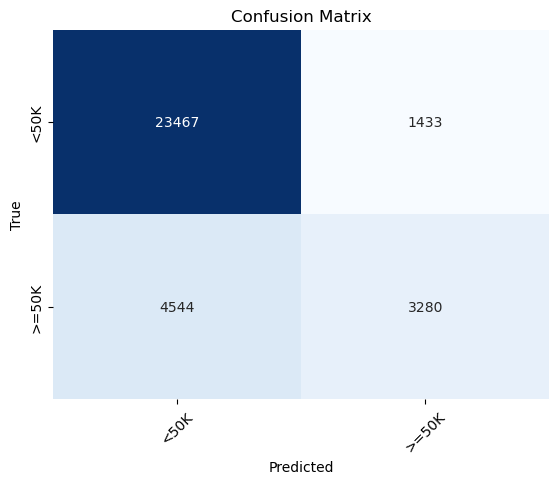

In [48]:
class_labels = ['<50K', '>=50K']
fig_nbr, ax_nbr = plt.subplots()

# Create a heatmap using seaborn
heatmap = sns.heatmap(cm_nbr_, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax_nbr)

ax_nbr.set_xlabel('Predicted')
ax_nbr.set_ylabel('True')
ax_nbr.set_title('Confusion Matrix')
ax_nbr.xaxis.set_ticklabels(class_labels)
ax_nbr.yaxis.set_ticklabels(class_labels)
plt.xticks(rotation=45)

(array([0.5, 1.5]), [Text(0.5, 0, '<50K'), Text(1.5, 0, '>=50K')])

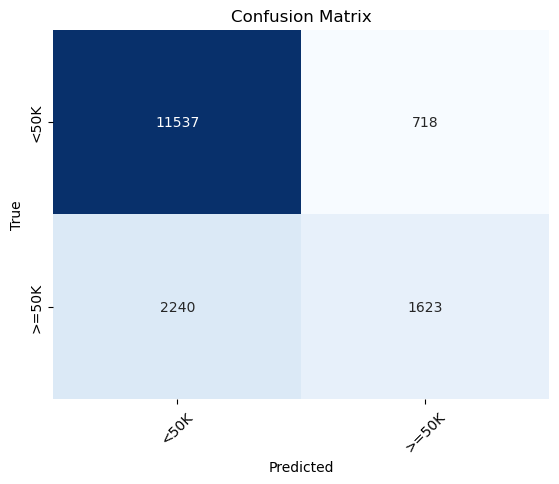

In [49]:
class_labels = ['<50K', '>=50K']
fig_nbr1, ax_nbr1 = plt.subplots()

# Create a heatmap using seaborn
heatmap = sns.heatmap(cm_nbr, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax_nbr1)

ax_nbr1.set_xlabel('Predicted')
ax_nbr1.set_ylabel('True')
ax_nbr1.set_title('Confusion Matrix')
ax_nbr1.xaxis.set_ticklabels(class_labels)
ax_nbr1.yaxis.set_ticklabels(class_labels)
fig_nbr1.savefig('CM_NaiveRandom.png')
plt.xticks(rotation=45)

In [72]:
with open('gnb_model_random.pkl', 'wb') as file:
    pickle.dump(naiveGaussRandom, file)

In [73]:
with open('gnb_model_random.pkl', 'rb') as file:
    naiveGaussRandom = pickle.load(file)

In [74]:
X_train_nbr, Y_train_nbr, X_test_nbr, Y_test_nbr = None, None, None, None

### Logistic Regression with Random

In [75]:
logRegRandom = LogisticRegression(penalty=None, random_state=0,max_iter=500, multi_class='ovr',n_jobs=4)
X_train_lrR, Y_train_lrR, X_test_lrR, Y_test_lrR = X_train.copy(), Y_train.copy(), X_test.copy(), Y_test.copy()
logRegRandom.fit(X_train_lrR, Y_train_lrR)

LogisticRegression(max_iter=500, multi_class='ovr', n_jobs=4, penalty=None,
                   random_state=0)

(array([0.5, 1.5]), [Text(0.5, 0, '<50K'), Text(1.5, 0, '>=50K')])

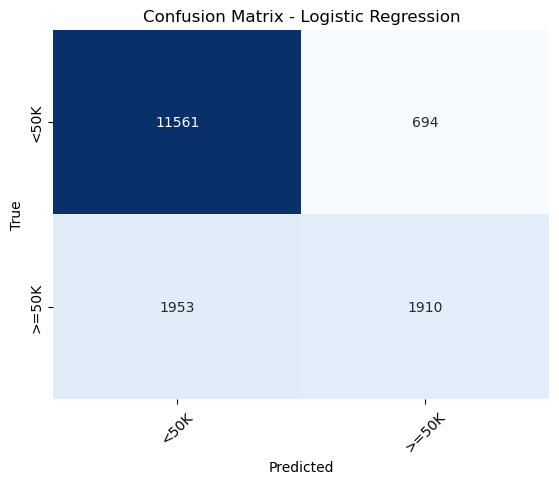

In [77]:
Y_pred_lrR = logRegRandom.predict(X_test_lrR)
cm_lrR = confusion_matrix(Y_test_lrR, Y_pred_lrR)
class_labels = ['<50K', '>=50K']
fig_lrR, ax_lrR = plt.subplots()

# Create a heatmap using seaborn
heatmap = sns.heatmap(cm_lrR, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax_lrR)

ax_lrR.set_xlabel('Predicted')
ax_lrR.set_ylabel('True')
ax_lrR.set_title('Confusion Matrix - Logistic Regression')
ax_lrR.xaxis.set_ticklabels(class_labels)
ax_lrR.yaxis.set_ticklabels(class_labels)
fig_lrR.savefig('CM_LogisticRandom.png')
plt.xticks(rotation=45)

In [78]:
logRegRandom.score(X_train_lrR, Y_train_lrR)

0.8316831683168316

In [79]:
logRegRandom.score(X_test_lrR, Y_test_lrR)

0.8357736691897257

In [80]:
with open('lr_model_random.pkl','wb') as file:
    pickle.dump(logRegRandom, file)

In [81]:
with open('lr_model_random.pkl', 'rb') as file:
    logRegRandom = pickle.load(file)

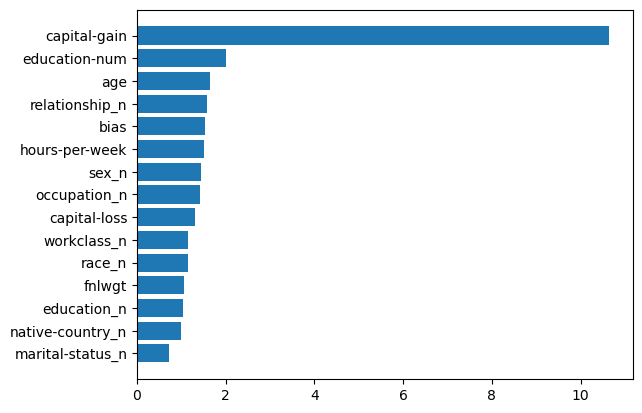

In [83]:
cw = logRegRandom.coef_[0]
cw0 = logRegRandom.intercept_[0]
feature_importance_lrR = pd.DataFrame(train_df.drop(columns='class_n', axis='columns').columns, columns = ["attribute"])
feature_importance_lrR["importance"] = pow(math.e, cw)

bias_row = pd.DataFrame({'attribute':['bias'], 
                         'importance':[abs(cw0)]}, index=[0])
feature_importance_lrR = pd.concat([feature_importance_lrR, bias_row], ignore_index=True)
feature_importance_lrR = feature_importance_lrR.sort_values(by = ["importance"], ascending=False)

fig_lrfiR, ax_lrfiR = plt.subplots()
ax_lrfiR.barh(feature_importance_lrR.attribute, feature_importance_lrR.importance)
ax_lrfiR.invert_yaxis()
fig_lrfiR.savefig('Logistic_FI_random.png')

In [84]:
cw,cw0

(array([ 0.50239895,  0.06241798,  0.69972453,  2.36553087,  0.27625578,
         0.40679473,  0.14577416,  0.03022086, -0.33564394,  0.34494034,
         0.45734211,  0.13318496,  0.36153185, -0.01525545]),
 -1.534844087484672)

Equation of the Logistic Regression:
$$ y = 0.50239895x_{14} + 0.06241798x_{13} + 0.69972453x_{12} + 2.36553087x_{11} + 0.27625578x_{10} + 0.40679473x_{9} + 0.14577416x_8 + 0.03022086x_7 - 0.33564394x_6 + 0.34494034x_5 + 0.45734211x_4 + 0.13318496x_3 + 0.36153185x_2 + 0.36153185x - 1.534844087484672 $$
where x represent as follows: 14:age, 13:fnlwgt, 12:education-num, 11:capital-gain, 10:capital-loss, 9:hours-per-week, 8:workclass_n, 7:education_n, 6:marital-status_n, 5:occupation_n, 4:relationship_n, 3:race_n, 2:sex_n, 1:native-country_n, 0:bias

In [85]:
X_train_lrR, Y_train_lrR, X_test_lrR, Y_test_lrR = None, None, None, None

### Neural Network with 1 Hidden Layer on Random Data

In [87]:
X_train_nn1, Y_train_nn1, X_test_nn1, Y_test_nn1 = X_train.copy(), Y_train.copy(), X_test.copy(), Y_test.copy()
X_train_nn1.shape, Y_train_nn1.shape

((32724, 14), (32724,))

In [88]:
X_train_nn1 = torch.from_numpy(X_train_nn1).type(torch.float32)
Y_train_nn1 = torch.from_numpy(Y_train_nn1.to_numpy()).type(torch.float32)
X_test_nn1 = torch.from_numpy(X_test_nn1).type(torch.float32)
Y_test_nn1 = torch.from_numpy(Y_test_nn1.to_numpy()).type(torch.float32)
X_train_nn1[:5],Y_train_nn1[:5]

(tensor([[ 0.0260, -0.1619,  1.5255, -0.1448, -0.2171,  0.3694, -0.0416,  1.0402,
          -0.4104,  1.0462,  0.6106,  0.3833,  0.7042,  0.2597],
         [-1.2139, -0.3691, -0.4193, -0.1448, -0.2171, -1.6481, -0.0416,  0.6916,
           0.9161, -0.2903,  1.2592,  0.3833,  0.7042,  0.2597],
         [-0.1199,  0.2159, -0.4193, -0.1448, -0.2171, -0.0341, -0.0416,  0.6916,
          -0.4104, -0.0230,  0.6106,  0.3833,  0.7042,  0.2597],
         [-1.3598,  0.7649, -0.4193, -0.1448, -0.2171, -0.0341, -0.0416,  0.6916,
           0.9161, -0.8249,  1.2592,  0.3833,  0.7042,  0.2597],
         [ 2.5059,  0.5029, -0.4193,  0.3210, -0.2171, -0.0341, -0.0416,  0.6916,
          -0.4104, -0.8249,  0.6106,  0.3833,  0.7042, -4.7142]]),
 tensor([1., 0., 0., 0., 0.]))

In [89]:
X_test_nn1, X_valid_nn1, Y_test_nn1, Y_valid_nn1 = train_test_split(X_test_nn1, Y_test_nn1, train_size=0.5, random_state=10)
X_test_nn1.shape, X_valid_nn1.shape

(torch.Size([8059, 14]), torch.Size([8059, 14]))

In [90]:
model_nn1R = nn.Sequential(nn.Linear(in_features=14, out_features=10),#Input Layer to Hidden Layer
                          nn.Sigmoid(),#Non-Linear Function
                          nn.Linear(in_features=10, out_features=1))#Hidden Layer to Output Layer

In [91]:
loss_nn1R = nn.BCEWithLogitsLoss()#Non-Linear Function to get probability of class inclusive here
grad_nn1R = torch.optim.SGD(model_nn1R.parameters(), lr=0.001)

In [92]:
torch.manual_seed(6)
train_loss_values = []
test_loss_values = []
epoch_count = []
train_accuracy_values = []
valid_accuracy_values = []
for epoch in range(10000):
    ## Training    
    # Set Training mode
    model_nn1R.train()
    
    # Forward Pass
    y_pred_nn1logits = model_nn1R(X_train_nn1).squeeze()
    y_pred_nn1 = torch.round(torch.sigmoid(y_pred_nn1logits))
    
    # Calculating loss
    losstrain = loss_nn1R(y_pred_nn1logits, Y_train_nn1)
    
    epoch_count.append(epoch)
    train_loss_values.append(losstrain.item())
    train_acc = accuracy_fn(y_true=Y_train_nn1, y_pred=y_pred_nn1)
    train_accuracy_values.append(train_acc)
    
    # Zero Grad of optimizer
    grad_nn1R.zero_grad()
    
    # Backward Propogation
    losstrain.backward()
    
    # Progress the optimizer
    grad_nn1R.step()
    
    ## Validation
    # Setting evaluation mode
    model_nn1R.eval()
    
    with torch.inference_mode():
        valid_predlogits = model_nn1R(X_valid_nn1).squeeze()
        valid_pred = torch.round(torch.sigmoid(valid_predlogits))
        loss_valid = loss_nn1R(valid_predlogits, Y_valid_nn1)
        test_loss_values.append(loss_valid.item())
        valid_acc = accuracy_fn(y_true=Y_valid_nn1, y_pred=valid_pred)
        valid_accuracy_values.append(valid_acc)
        
    if epoch%500==0:
        print(f"Epoch: {epoch} | Loss: {losstrain.item()}, Accuracy: {train_acc:.2f}% | Test Loss: {loss_valid.item()}, Test Accuracy: {valid_acc:.2f}%")

Epoch: 0 | Loss: 0.7221164107322693, Accuracy: 22.88% | Test Loss: 0.7219921350479126, Test Accuracy: 23.24%
Epoch: 500 | Loss: 0.6351794600486755, Accuracy: 76.09% | Test Loss: 0.6362184882164001, Test Accuracy: 75.82%
Epoch: 1000 | Loss: 0.5969881415367126, Accuracy: 76.09% | Test Loss: 0.5987575650215149, Test Accuracy: 75.82%
Epoch: 1500 | Loss: 0.5791622996330261, Accuracy: 76.09% | Test Loss: 0.5813971757888794, Test Accuracy: 75.82%
Epoch: 2000 | Loss: 0.5701901912689209, Accuracy: 76.09% | Test Loss: 0.5727230906486511, Test Accuracy: 75.82%
Epoch: 2500 | Loss: 0.5652512907981873, Accuracy: 76.09% | Test Loss: 0.5679733157157898, Test Accuracy: 75.82%
Epoch: 3000 | Loss: 0.5622280240058899, Accuracy: 76.09% | Test Loss: 0.5650664567947388, Test Accuracy: 75.82%
Epoch: 3500 | Loss: 0.5601477026939392, Accuracy: 76.09% | Test Loss: 0.5630531311035156, Test Accuracy: 75.82%
Epoch: 4000 | Loss: 0.5585470795631409, Accuracy: 76.09% | Test Loss: 0.5614852905273438, Test Accuracy: 75.

In [93]:
model_nn1R.eval()
with torch.inference_mode():
    train_pred = model_nn1R(X_train_nn1).squeeze()
    
train_pred = torch.round(torch.sigmoid(train_pred))
train_acc = accuracy_fn(y_true=Y_train_nn1, y_pred=train_pred)
cm_nn1R_train = confusion_matrix(Y_train_nn1, train_pred)
train_acc

76.0909424275761

In [94]:
model_nn1R.eval()
with torch.inference_mode():
    test_pred = model_nn1R(X_test_nn1).squeeze()
    
test_pred = torch.round(torch.sigmoid(test_pred))
test_acc = accuracy_fn(y_true=Y_test_nn1, y_pred=test_pred)
cm_nn1R_test = confusion_matrix(Y_test_nn1, test_pred)
test_acc

76.25015510609256

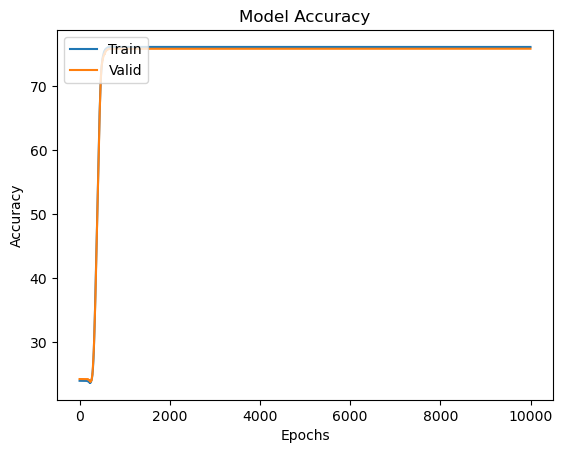

In [94]:
plt.plot(epoch_count, train_accuracy_values)
plt.plot(epoch_count, valid_accuracy_values)
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train','Valid'], loc='upper left')
plt.savefig('Acc1HiddenR.png')

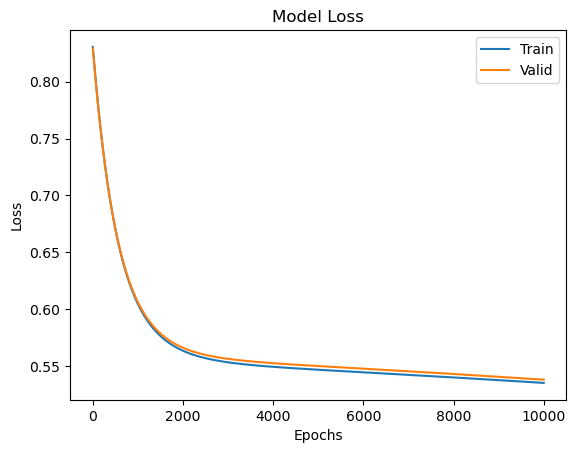

In [95]:
plt.plot(epoch_count, train_loss_values)
plt.plot(epoch_count, test_loss_values)
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train','Valid'], loc='upper right')
plt.savefig('Loss1HiddenR.png')

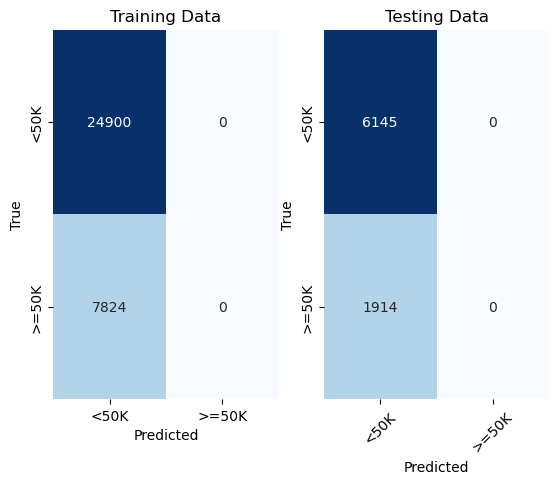

In [63]:
fignn1R, axnn1R = plt.subplots(1,2)
heatmap = sns.heatmap(cm_nn1R_train, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axnn1R[0])

axnn1R[0].set_xlabel('Predicted')
axnn1R[0].set_ylabel('True')
axnn1R[0].xaxis.set_ticklabels(class_labels)
axnn1R[0].yaxis.set_ticklabels(class_labels)
plt.xticks(rotation=45)

heatmap1 = sns.heatmap(cm_nn1R_test, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axnn1R[1])

axnn1R[1].set_xlabel('Predicted')
axnn1R[1].set_ylabel('True')
axnn1R[1].xaxis.set_ticklabels(class_labels)
axnn1R[1].yaxis.set_ticklabels(class_labels)
plt.xticks(rotation=45)

axnn1R[0].set_title('Training Data')
axnn1R[1].set_title('Testing Data')
figst.savefig('CompareCMNN1R.png')

In [96]:
torch.save(model_nn1.state_dict(), f="NN1R.pth")

In [57]:
model_nn1R.load_state_dict(torch.load(f='NN1R.pth'))

<All keys matched successfully>

In [64]:
X_train_nn1, Y_train_nn1, X_test_nn1, X_valid_nn1, Y_test_nn1, Y_valid_nn1 = None, None, None, None, None, None

### Neural Network with 2 Hidden Layer on Random data

In [66]:
X_train_nn2R, Y_train_nn2R, X_test_nn2R, Y_test_nn2R = X_train.copy(), Y_train.copy(), X_test.copy(), Y_test.copy()
X_train_nn2R.shape, Y_train_nn2R.shape

((32724, 14), (32724,))

In [67]:
X_train_nn2R = torch.from_numpy(X_train_nn2R).type(torch.float32)
Y_train_nn2R = torch.from_numpy(Y_train_nn2R.to_numpy()).type(torch.float32)
X_test_nn2R = torch.from_numpy(X_test_nn2R).type(torch.float32)
Y_test_nn2R = torch.from_numpy(Y_test_nn2R.to_numpy()).type(torch.float32)
X_train_nn2R[:5],Y_train_nn2R[:5]

(tensor([[ 0.0260, -0.1619,  1.5255, -0.1448, -0.2171,  0.3694, -0.0416,  1.0402,
          -0.4104,  1.0462,  0.6106,  0.3833,  0.7042,  0.2597],
         [-1.2139, -0.3691, -0.4193, -0.1448, -0.2171, -1.6481, -0.0416,  0.6916,
           0.9161, -0.2903,  1.2592,  0.3833,  0.7042,  0.2597],
         [-0.1199,  0.2159, -0.4193, -0.1448, -0.2171, -0.0341, -0.0416,  0.6916,
          -0.4104, -0.0230,  0.6106,  0.3833,  0.7042,  0.2597],
         [-1.3598,  0.7649, -0.4193, -0.1448, -0.2171, -0.0341, -0.0416,  0.6916,
           0.9161, -0.8249,  1.2592,  0.3833,  0.7042,  0.2597],
         [ 2.5059,  0.5029, -0.4193,  0.3210, -0.2171, -0.0341, -0.0416,  0.6916,
          -0.4104, -0.8249,  0.6106,  0.3833,  0.7042, -4.7142]]),
 tensor([1., 0., 0., 0., 0.]))

In [68]:
X_test_nn2R, X_valid_nn2R, Y_test_nn2R, Y_valid_nn2R = train_test_split(X_test_nn2R, Y_test_nn2R, train_size=0.5, random_state=0)
X_test_nn2R.shape, X_valid_nn2R.shape

(torch.Size([8059, 14]), torch.Size([8059, 14]))

In [69]:
model_nn2R = nn.Sequential(nn.Linear(in_features=14, out_features=9),#Input Layer to Hidden Layer
                          nn.Sigmoid(),#Non-Linear Function
                          nn.Linear(in_features=9, out_features=9),#Hidden Layer to Hidden Layer
                          nn.Sigmoid(),#Non-Linear Function
                          nn.Linear(in_features=9, out_features=1))#Hidden Layer to Output Layer

In [70]:
loss_nn2R = nn.BCEWithLogitsLoss()#Non-Linear Function to get probability of class inclusive here
grad_nn2R = torch.optim.SGD(model_nn2R.parameters(), lr=0.001)

In [14]:
torch.manual_seed(6)
train_loss_values2 = []
test_loss_values2 = []
epoch_count2 = []
train_accuracy_values2 = []
valid_accuracy_values2 = []
for epoch in range(10000):
    ## Training    
    # Set Training mode
    model_nn2R.train()
    
    # Forward Pass
    y_pred_nn2logits = model_nn2R(X_train_nn2R).squeeze()
    y_pred_nn2 = torch.round(torch.sigmoid(y_pred_nn2logits))
    
    # Calculating loss
    losstrain = loss_nn2R(y_pred_nn2logits, Y_train_nn2R)
    
    epoch_count2.append(epoch)
    train_loss_values2.append(losstrain.item())
    train_acc = accuracy_fn(y_true=Y_train_nn2R, y_pred=y_pred_nn2)
    train_accuracy_values2.append(train_acc)
    
    # Zero Grad of optimizer
    grad_nn2R.zero_grad()
    
    # Backward Propogation
    losstrain.backward()
    
    # Progress the optimizer
    grad_nn2R.step()
    
    ## Validation
    # Setting evaluation mode
    model_nn2R.eval()
    
    with torch.inference_mode():
        valid_predlogits = model_nn2R(X_valid_nn2R).squeeze()
        valid_pred = torch.round(torch.sigmoid(valid_predlogits))
        loss_valid = loss_nn2R(valid_predlogits, Y_valid_nn2R)
        test_loss_values2.append(loss_valid.item())
        valid_acc = accuracy_fn(y_true=Y_valid_nn2R, y_pred=valid_pred)
        valid_accuracy_values2.append(valid_acc)
        
    if epoch%500==0:
        print(f"Epoch: {epoch} | Loss: {losstrain.item()}, Accuracy: {train_acc:.2f}% | Test Loss: {loss_valid.item()}, Test Accuracy: {valid_acc:.2f}%")

Epoch: 0 | Loss: 0.7170917987823486, Accuracy: 23.91% | Test Loss: 0.7164486646652222, Test Accuracy: 24.38%
Epoch: 500 | Loss: 0.6271806359291077, Accuracy: 76.09% | Test Loss: 0.6284598112106323, Test Accuracy: 75.62%
Epoch: 1000 | Loss: 0.5866732001304626, Accuracy: 76.09% | Test Loss: 0.5892166495323181, Test Accuracy: 75.62%
Epoch: 1500 | Loss: 0.567832887172699, Accuracy: 76.09% | Test Loss: 0.571227490901947, Test Accuracy: 75.62%
Epoch: 2000 | Loss: 0.5587666034698486, Accuracy: 76.09% | Test Loss: 0.5627464652061462, Test Accuracy: 75.62%
Epoch: 2500 | Loss: 0.5542719960212708, Accuracy: 76.09% | Test Loss: 0.5586606860160828, Test Accuracy: 75.62%
Epoch: 3000 | Loss: 0.5519853234291077, Accuracy: 76.09% | Test Loss: 0.5566629767417908, Test Accuracy: 75.62%
Epoch: 3500 | Loss: 0.5507924556732178, Accuracy: 76.09% | Test Loss: 0.5556759238243103, Test Accuracy: 75.62%
Epoch: 4000 | Loss: 0.5501520037651062, Accuracy: 76.09% | Test Loss: 0.5551827549934387, Test Accuracy: 75.62

In [71]:
model_nn2R.eval()
with torch.inference_mode():
    train_pred = model_nn2R(X_train_nn2R).squeeze()
    
train_pred = torch.round(torch.sigmoid(train_pred))
train_acc = accuracy_fn(y_true=Y_train_nn2R, y_pred=train_pred)
cm_nn2R_train = confusion_matrix(Y_train_nn2R, train_pred)
train_acc

76.0909424275761

In [72]:
model_nn2R.eval()
with torch.inference_mode():
    test_pred = model_nn2R(X_test_nn2R).squeeze()
    
test_pred = torch.round(torch.sigmoid(test_pred))
test_acc = accuracy_fn(y_true=Y_test_nn2R, y_pred=test_pred)
cm_nn2R_test = confusion_matrix(Y_test_nn2R, test_pred)
test_acc

76.44869090457873

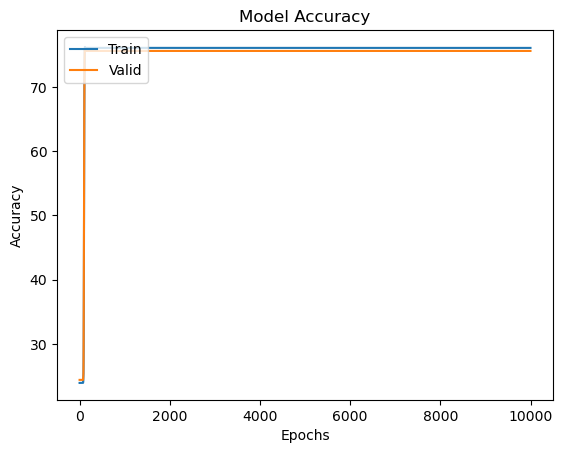

In [19]:
plt.plot(epoch_count2, train_accuracy_values2)
plt.plot(epoch_count2, valid_accuracy_values2)
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train','Valid'], loc='upper left')
plt.savefig('Acc2HiddenR.png')

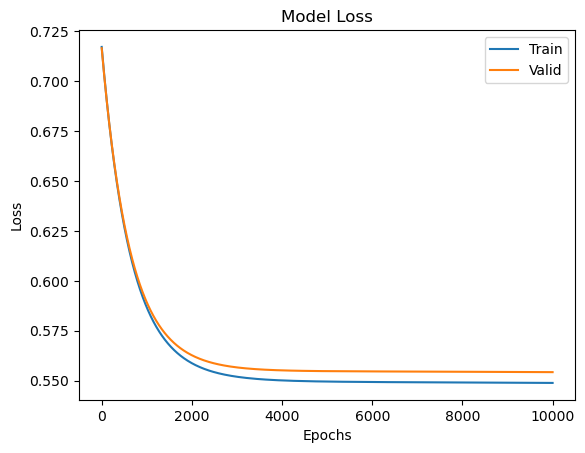

In [20]:
plt.plot(epoch_count2, train_loss_values2)
plt.plot(epoch_count2, test_loss_values2)
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train','Valid'], loc='upper right')
plt.savefig('Loss2HiddenR.png')

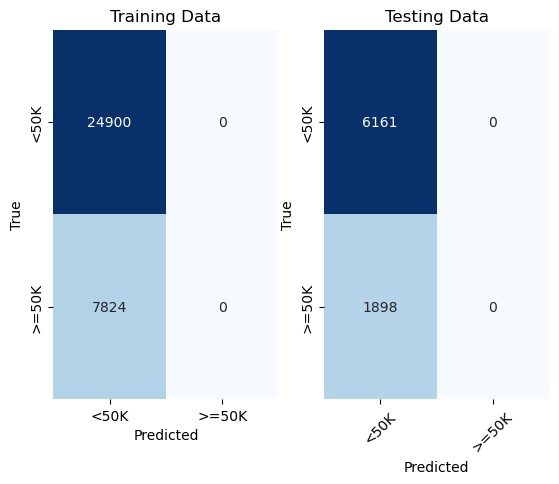

In [73]:
fignn2R, axnn2R = plt.subplots(1,2)
heatmap = sns.heatmap(cm_nn2R_train, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axnn2R[0])

axnn2R[0].set_xlabel('Predicted')
axnn2R[0].set_ylabel('True')
axnn2R[0].xaxis.set_ticklabels(class_labels)
axnn2R[0].yaxis.set_ticklabels(class_labels)
plt.xticks(rotation=45)

heatmap1 = sns.heatmap(cm_nn2R_test, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axnn2R[1])

axnn2R[1].set_xlabel('Predicted')
axnn2R[1].set_ylabel('True')
axnn2R[1].xaxis.set_ticklabels(class_labels)
axnn2R[1].yaxis.set_ticklabels(class_labels)
plt.xticks(rotation=45)

axnn2R[0].set_title('Training Data')
axnn2R[1].set_title('Testing Data')
figst.savefig('CompareCMNN2R.png')

In [22]:
torch.save(model_nn2R.state_dict(),f='NN2R.pth')

In [23]:
model_nn2R.load_state_dict(torch.load(f='NN2R.pth'))

<All keys matched successfully>

In [74]:
X_train_nn2R, Y_train_nn2R, X_test_nn2R, X_valid_nn2R, Y_test_nn2R, Y_valid_nn2R = None, None, None, None, None, None

### Neural Network with 3 Hidden Layers on Random data

In [95]:
X_train_nn3R, Y_train_nn3R, X_test_nn3R, Y_test_nn3R = X_train.copy(), Y_train.copy(), X_test.copy(), Y_test.copy()
X_train_nn3R.shape, Y_train_nn3R.shape

((32724, 14), (32724,))

In [96]:
X_train_nn3R = torch.from_numpy(X_train_nn3R).type(torch.float32)
Y_train_nn3R = torch.from_numpy(Y_train_nn3R.to_numpy()).type(torch.float32)
X_test_nn3R = torch.from_numpy(X_test_nn3R).type(torch.float32)
Y_test_nn3R = torch.from_numpy(Y_test_nn3R.to_numpy()).type(torch.float32)
X_train_nn3R[:5],Y_train_nn3R[:5]

(tensor([[ 0.0260, -0.1619,  1.5255, -0.1448, -0.2171,  0.3694, -0.0416,  1.0402,
          -0.4104,  1.0462,  0.6106,  0.3833,  0.7042,  0.2597],
         [-1.2139, -0.3691, -0.4193, -0.1448, -0.2171, -1.6481, -0.0416,  0.6916,
           0.9161, -0.2903,  1.2592,  0.3833,  0.7042,  0.2597],
         [-0.1199,  0.2159, -0.4193, -0.1448, -0.2171, -0.0341, -0.0416,  0.6916,
          -0.4104, -0.0230,  0.6106,  0.3833,  0.7042,  0.2597],
         [-1.3598,  0.7649, -0.4193, -0.1448, -0.2171, -0.0341, -0.0416,  0.6916,
           0.9161, -0.8249,  1.2592,  0.3833,  0.7042,  0.2597],
         [ 2.5059,  0.5029, -0.4193,  0.3210, -0.2171, -0.0341, -0.0416,  0.6916,
          -0.4104, -0.8249,  0.6106,  0.3833,  0.7042, -4.7142]]),
 tensor([1., 0., 0., 0., 0.]))

In [97]:
X_test_nn3R, X_valid_nn3R, Y_test_nn3R, Y_valid_nn3R = train_test_split(X_test_nn3R, Y_test_nn3R, train_size=0.5, random_state=0)
X_test_nn3R.shape, X_valid_nn3R.shape

(torch.Size([8059, 14]), torch.Size([8059, 14]))

In [98]:
model_nn3R = nn.Sequential(nn.Linear(in_features=14, out_features=9),#Input Layer to Hidden Layer1
                          nn.Sigmoid(),#Non-Linear Function
                          nn.Linear(in_features=9, out_features=9),#Hidden Layer1 to Hidden Layer2
                          nn.Sigmoid(),#Non-Linear Function
                          nn.Linear(in_features=9, out_features=9),#Hidden Layer2 to Hidden Layer3
                          nn.Sigmoid(),#Non-Linear Function
                          nn.Linear(in_features=9, out_features=1))#Hidden Layer3 to Output Layer

In [99]:
loss_nn3R = nn.BCEWithLogitsLoss()#Non-Linear Function to get probability of class inclusive here
grad_nn3R = torch.optim.SGD(model_nn3R.parameters(), lr=0.001)

In [34]:
torch.manual_seed(6)
train_loss_values3 = []
test_loss_values3 = []
epoch_count3 = []
train_accuracy_values3 = []
valid_accuracy_values3 = []
for epoch in range(10000):
    ## Training    
    # Set Training mode
    model_nn3R.train()
    
    # Forward Pass
    y_pred_nn3logits = model_nn3R(X_train_nn3R).squeeze()
    y_pred_nn3 = torch.round(torch.sigmoid(y_pred_nn3logits))
    
    # Calculating loss
    losstrain = loss_nn3R(y_pred_nn3logits, Y_train_nn3R)
    
    epoch_count3.append(epoch)
    train_loss_values3.append(losstrain.item())
    train_acc = accuracy_fn(y_true=Y_train_nn3R, y_pred=y_pred_nn3)
    train_accuracy_values3.append(train_acc)
    
    # Zero Grad of optimizer
    grad_nn3R.zero_grad()
    
    # Backward Propogation
    losstrain.backward()
    
    # Progress the optimizer
    grad_nn3R.step()
    
    ## Validation
    # Setting evaluation mode
    model_nn3R.eval()
    
    with torch.inference_mode():
        valid_predlogits = model_nn3R(X_valid_nn3R).squeeze()
        valid_pred = torch.round(torch.sigmoid(valid_predlogits))
        loss_valid = loss_nn3R(valid_predlogits, Y_valid_nn3R)
        test_loss_values3.append(loss_valid.item())
        valid_acc = accuracy_fn(y_true=Y_valid_nn3R, y_pred=valid_pred)
        valid_accuracy_values3.append(valid_acc)
        
    if epoch%500==0:
        print(f"Epoch: {epoch} | Loss: {losstrain.item()}, Accuracy: {train_acc:.2f}% | Test Loss: {loss_valid.item()}, Test Accuracy: {valid_acc:.2f}%")

Epoch: 0 | Loss: 0.7997727394104004, Accuracy: 23.91% | Test Loss: 0.7977226972579956, Test Accuracy: 24.38%
Epoch: 500 | Loss: 0.6665714979171753, Accuracy: 76.09% | Test Loss: 0.6669029593467712, Test Accuracy: 75.62%
Epoch: 1000 | Loss: 0.6061744689941406, Accuracy: 76.09% | Test Loss: 0.6080610752105713, Test Accuracy: 75.62%
Epoch: 1500 | Loss: 0.5779739618301392, Accuracy: 76.09% | Test Loss: 0.5809035301208496, Test Accuracy: 75.62%
Epoch: 2000 | Loss: 0.5643200278282166, Accuracy: 76.09% | Test Loss: 0.5679678320884705, Test Accuracy: 75.62%
Epoch: 2500 | Loss: 0.5574976801872253, Accuracy: 76.09% | Test Loss: 0.5616502165794373, Test Accuracy: 75.62%
Epoch: 3000 | Loss: 0.5540036559104919, Accuracy: 76.09% | Test Loss: 0.5585160255432129, Test Accuracy: 75.62%
Epoch: 3500 | Loss: 0.5521805286407471, Accuracy: 76.09% | Test Loss: 0.5569522976875305, Test Accuracy: 75.62%
Epoch: 4000 | Loss: 0.5512158274650574, Accuracy: 76.09% | Test Loss: 0.556175947189331, Test Accuracy: 75.6

In [82]:
model_nn3R.eval()
with torch.inference_mode():
    train_pred = model_nn3R(X_train_nn3R).squeeze()
    
train_pred = torch.round(torch.sigmoid(train_pred))
train_acc = accuracy_fn(y_true=Y_train_nn3R, y_pred=train_pred)
cm_nn3R_train = confusion_matrix(Y_train_nn3R, train_pred)
train_acc

76.0909424275761

In [84]:
model_nn3R.eval()
with torch.inference_mode():
    test_pred = model_nn3R(X_test_nn3R).squeeze()
    
test_pred = torch.round(torch.sigmoid(test_pred))
test_acc = accuracy_fn(y_true=Y_test_nn3R, y_pred=test_pred)
cm_nn3R_test = confusion_matrix(Y_test_nn3R, test_pred)
test_acc

76.44869090457873

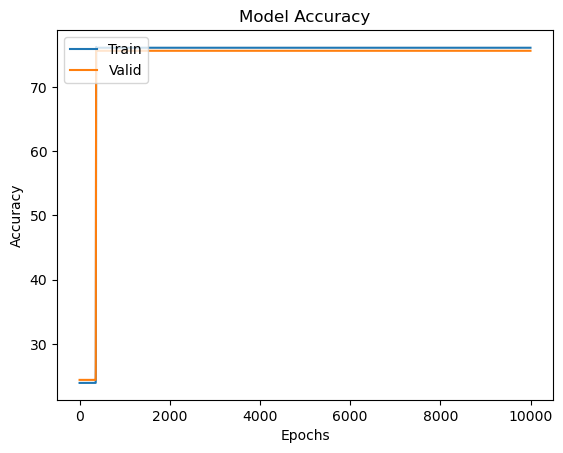

In [37]:
plt.plot(epoch_count3, train_accuracy_values3)
plt.plot(epoch_count3, valid_accuracy_values3)
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train','Valid'], loc='upper left')
plt.savefig('Acc3HiddenR.png')

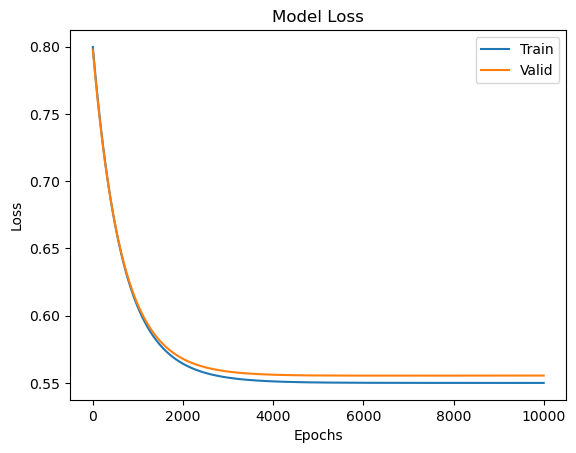

In [38]:
plt.plot(epoch_count3, train_loss_values3)
plt.plot(epoch_count3, test_loss_values3)
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train','Valid'], loc='upper right')
plt.savefig('Loss3HiddenR.png')

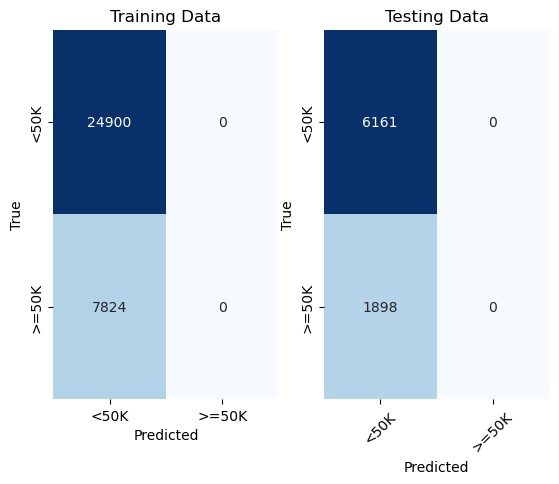

In [85]:
fignn3R, axnn3R = plt.subplots(1,2)
heatmap = sns.heatmap(cm_nn3R_train, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axnn3R[0])

axnn3R[0].set_xlabel('Predicted')
axnn3R[0].set_ylabel('True')
axnn3R[0].xaxis.set_ticklabels(class_labels)
axnn3R[0].yaxis.set_ticklabels(class_labels)
plt.xticks(rotation=45)

heatmap1 = sns.heatmap(cm_nn3R_test, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axnn3R[1])

axnn3R[1].set_xlabel('Predicted')
axnn3R[1].set_ylabel('True')
axnn3R[1].xaxis.set_ticklabels(class_labels)
axnn3R[1].yaxis.set_ticklabels(class_labels)
plt.xticks(rotation=45)

axnn3R[0].set_title('Training Data')
axnn3R[1].set_title('Testing Data')
figst.savefig('CompareCMNN3R.png')

In [39]:
torch.save(model_nn3R.state_dict(),f='NN3R.pth')

In [100]:
model_nn3R.load_state_dict(torch.load(f='NN3R.pth'))

<All keys matched successfully>

In [107]:
model_nn3R.eval()
with torch.inference_mode():
    test_pred = model_nn3R(X_test_nn3R).squeeze()
results = {'0.4':0,'0.3':0,'0.2':0,'0.1':0,'0.0':0}
test_pred = (torch.sigmoid(test_pred))
for i in range(0,len(Y_test_nn3R)):
    if Y_test_nn3R[i]==1:
        if test_pred[i]>=0.4:
            results['0.4']+=1
        elif test_pred[i]>=0.3:
            results['0.3']+=1
        elif test_pred[i]>=0.2:
            results['0.2']+=1
        elif test_pred[i]>=0.1:
            results['0.1']+=1
        else:
            results['0.0']+=1
results

{'0.4': 0, '0.3': 0, '0.2': 1898, '0.1': 0, '0.0': 0}

In [86]:
X_train_nn3R, Y_train_nn3R, X_test_nn3R, X_valid_nn3R, Y_test_nn3R, Y_valid_nn3R = None, None, None, None, None, None

### Studying the Results obained so far
The results for all the models we have created so far give us some insight on the data as well as its distribution. The training and testing data both have more <50K class, and the lack of >=50K class creates a problem for the model to recogonize it perfectly. This can be demonstrated using the confusion matrix for training and testing data.

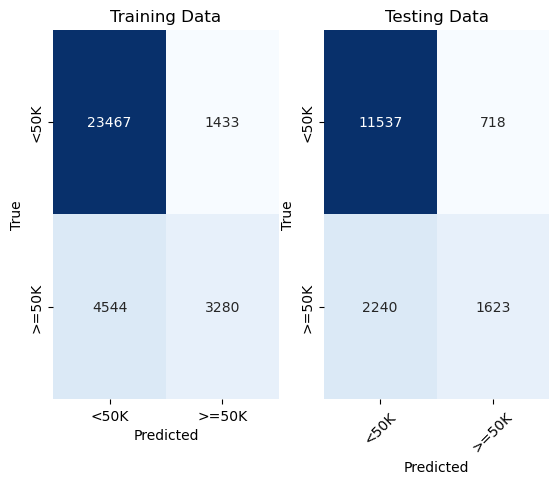

In [54]:
figst, axst = plt.subplots(1,2)
heatmap = sns.heatmap(cm_nbr_, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axst[0])

axst[0].set_xlabel('Predicted')
axst[0].set_ylabel('True')
axst[0].xaxis.set_ticklabels(class_labels)
axst[0].yaxis.set_ticklabels(class_labels)
plt.xticks(rotation=45)

heatmap1 = sns.heatmap(cm_nbr, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axst[1])

axst[1].set_xlabel('Predicted')
axst[1].set_ylabel('True')
axst[1].xaxis.set_ticklabels(class_labels)
axst[1].yaxis.set_ticklabels(class_labels)
plt.xticks(rotation=45)

axst[0].set_title('Training Data')
axst[1].set_title('Testing Data')
figst.savefig('CompareCMNBR.png')

Here, comparing the Confusion Matrices for training and testing data, we can clearly observe that the matrix is correctly classifying the <50K class, where as it is failing to do so with accuracy for >=50K class. The reason is also apparent, which is due to the fact that the overall data has low amount of training for >=50K class, causing the model to fail in learning the generality of the said data.

#### Naive Bayes Classifier
Obtaining a score of 0.8192008844937195 for training and 0.8161046618758061 for testing data, this model is able to correctly predict more of >=50K classes compared to <50K classes. But if we randomly take data for training and testing in the combined data, we observe 0.8173511795624007 and 0.8164784712743517 for training and testing data, which is only a miniscule improvement.
#### Logistic Regression Model
Moving to Logistic Regression Model, we obtain 0.8327139829857806 and 0.8300472943922363 for training and testing on given dataset, which is better compared to NB model. It also shows the similar results, but is somewhat better in classifying >=50K class. For Random datasets, we get 0.8316831683168316 and 0.8357736691897257 for training and testing, which is a 0.5% improvement in testing, showing that the random dataset is better in generalizing the result.
#### Neural Network
For given dataset, we get 75.91904425539757 and 76.8058968058968 for training and testing, we observe that the confusion matrix basically predicts the >=50K class to be 0. This is not an accurate description, as the Neural Network returns the probability of data, and we have forcibly rounded them off to comprehend the data, resulting in the low probabilities being converted to 0. Since we don't have another metric with our current knowledge to quantify our result, we're left with this output. So, for random dataset, we get 76.0909424275761 and 76.25015510609256 for training and testing, which again is constant through the three layer changes, so how do we quantify the usefulness of hidden layers?

We will look at the data yielded while training, which are the loss and accuracy graphs. These graphs become deeper and stabler as the no. of hidden layers increase. We can also observe that as we go from given to random data, the graph for valid and train data indicate, whcih allow us to decide where to stop training to get a more generalized result.

Another method is to change our threshhold for probability calculation from 0.5 to a ratio which represents testing/training data, but the vailidity of this method needs to be clarified.

### Ranking the classifiers
So far, we have classified the given data to get final salary classes, using 5 methods. Among those, the efficacy of Decision Tree has been the highest with accuracy of 85.92% on testing data, given we perform post pruning. Following this with accuracy of 85.47% on testing data is Random Forest Classifier. Following this is logistic regression model with accuracy of 83.58%, followed by Naive Bayes Classifier, with accuracy 81.65%. Neural Network in general ranked the lowest with accuracy only reaching 76.81%, but this is arguable since our method of accuracy calculation in not verified. To finalize, we can say that our models have been Ranked as:
- Decision Tree
- Random Forest
- Logistic Regression
- Naive Bayes
- Neural Network

but if we can obtain correct data, which has equal amount of both classes, or correct accuracy threshold, we can with guarantee state that Neural Network can give the most general result, whcih can be proven from the fact that while there is a big gap in the training and testing accuracy for all the other models, the training accuracy and testing accuracy of Neural Networks are similar, showing the genrality of the result.

In [107]:
model_nn3R.eval()
with torch.inference_mode():
    test_pred = model_nn3R(X_test_nn3R).squeeze()
results = {'0.4':0,'0.3':0,'0.2':0,'0.1':0,'0.0':0}
test_pred = (torch.sigmoid(test_pred))
for i in range(0,len(Y_test_nn3R)):
    if Y_test_nn3R[i]==1:
        if test_pred[i]>=0.4:
            results['0.4']+=1
        elif test_pred[i]>=0.3:
            results['0.3']+=1
        elif test_pred[i]>=0.2:
            results['0.2']+=1
        elif test_pred[i]>=0.1:
            results['0.1']+=1
        else:
            results['0.0']+=1
results

{'0.4': 0, '0.3': 0, '0.2': 1898, '0.1': 0, '0.0': 0}

The above cell clearly shows that all answers lie between 0.2 and 0.3, which cannot be dismissed as a coincidence, and that the study needs to be further improved to improve our data. So for now, we can simply say that a pruned decision tree is the best classifier for this uneven data distribution, whereas the Neural Network gives the most general ditribution.